# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">About 7 hours</span>
* 2. Part B: <span style="color:red;">About 4 hours</span>
* 3. Part C: <span style="color:red;">About 3 hours</span>
* 4. Tests: <span style="color:red;">About 15 minutes</span>
* 5. Challenge 1: <span style="color:red;">About 1 hour</span>
* 6. Challenge 2: <span style="color:red;">About 1 hour</span>
* 7. Write-up: <span style="color:red;">About 10 minutes</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [2]:
plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

import cv2

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': plt.rcParams['axes.titlesize'],
                                 'fontweight' : plt.rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

In [3]:
#Your Code Here

class Corner:
    def __init__(self, center, x1, y1, x2, y2):
        self.center = center
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

def find_corners(img_file_path, cutoff=0.80, count_cutoff=4, iou_cutoff=0.50):
    img_gray = cv2.imread(img_file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    corners_map = {}
    counts = {}
    height, width = img.shape

    # Just a bunch of loops; could've made this much more elegant but once again I've 
    # spent way too much time on this lab
    def _detect_ratio_horizontal(i, j):
        if img[i][j] != 0:
            return None
   
        length = -1

        # MOVE IN THE LEFT DIRECTION
        k = 1

        while i - k >= 0:
            left = img[i - k][j]

            if left != 0:
                length = int((k * 2 + 1) / 3)
                k += 1
                break

            k += 1

        if length == -1:
            return None

        should_continue = False
        curr_length = 0

        while i - k >= 0:
            left = img[i - k][j]

            if left == 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        while i - k >= 0:
            left = img[i - k][j]

            if left != 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k = 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        # MOVE IN THE RIGHT DIRECTION
        while i + k < width:
            right = img[i + k][j]

            if right != 0:
                curr_length *= 2

                if min(curr_length, length * 3) / max(curr_length, length * 3) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        while i + k < width:
            right = img[i + k][j]

            if right == 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        while i + k < width:
            right = img[i + k][j]

            if right != 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    total_length = length * 7
                    x1, y1 = i - int(total_length / 2), j - int(total_length / 2)
                    x2, y2 = i + int(total_length / 2), j + int(total_length / 2)

                    return Corner((i, j), x1, y1, x2, y2)

                else:
                    return None

            curr_length += 1
            k += 1

        return None

    def _detect_ratio_vertical(i, j):
        if img[i][j] != 0:
            return None
   
        length = -1

        # MOVE IN THE UP DIRECTION
        k = 1

        while j - k >= 0:
            up = img[i][j - k]

            if up != 0:
                length = int((k * 2 + 1) / 3)
                k += 1
                break

            k += 1

        if length == -1:
            return None

        should_continue = False
        curr_length = 0

        while j - k >= 0:
            up = img[i][j - k]

            if up == 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        while j - k >= 0:
            up = img[i][j - k]

            if up != 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k = 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        # MOVE IN THE DOWN DIRECTION
        while j + k < height:
            down = img[i][j + k]

            if down != 0:
                curr_length *= 2

                if min(curr_length, length * 3) / max(curr_length, length * 3) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        while j + k < height:
            down = img[i][j + k]

            if down == 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        while j + k < height:
            down = img[i][j + k]

            if down != 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    total_length = length * 7
                    x1, y1 = i - int(total_length / 2), j - int(total_length / 2)
                    x2, y2 = i + int(total_length / 2), j + int(total_length / 2)

                    return Corner((i, j), x1, y1, x2, y2)

                else:
                    return None

            curr_length += 1
            k += 1

        return None

    def _detect_ratio_diagonal_1(i, j):
        if img[i][j] != 0:
            return None
   
        length = -1

        # MOVE IN THE LEFT-UP DIRECTION
        k = 1

        while i - k >= 0 and j - k >= 0:
            up = img[i - k][j - k]

            if up != 0:
                length = int((k * 2 + 1) / 3)
                k += 1
                break

            k += 1

        if length == -1:
            return None

        should_continue = False
        curr_length = 0

        while i - k >= 0 and j - k >= 0:
            up = img[i - k][j - k]

            if up == 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        while i - k >= 0 and j - k >= 0:
            up = img[i - k][j - k]

            if up != 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k = 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        # MOVE IN THE RIGHT-DOWN DIRECTION
        while i + k < width and j + k < height:
            down = img[i + k][j + k]

            if down != 0:
                curr_length *= 2

                if min(curr_length, length * 3) / max(curr_length, length * 3) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        while i + k < width and j + k < height:
            down = img[i + k][j + k]

            if down == 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        while i + k < width and j + k < height:
            down = img[i + k][j + k]

            if down != 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    total_length = length * 7
                    x1, y1 = i - int(total_length / 2), j - int(total_length / 2)
                    x2, y2 = i + int(total_length / 2), j + int(total_length / 2)

                    return Corner((i, j), x1, y1, x2, y2)

                else:
                    return None

            curr_length += 1
            k += 1

        return None

    def _detect_ratio_diagonal_2(i, j):
        if img[i][j] != 0:
            return None
   
        length = -1

        # MOVE IN THE LEFT-DOWN DIRECTION
        k = 1

        while i - k >= 0 and j + k < height:
            down = img[i - k][j + k]

            if down != 0:
                length = int((k * 2 + 1) / 3)
                k += 1
                break

            k += 1

        if length == -1:
            return None

        should_continue = False
        curr_length = 0

        while i - k >= 0 and j + k < height:
            down = img[i - k][j + k]

            if down == 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        while i - k >= 0 and j + k < height:
            down = img[i - k][j + k]

            if down != 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k = 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        # MOVE IN THE RIGHT-UP DIRECTION
        while i + k < width and j - k >= 0:
            up = img[i + k][j - k]

            if up != 0:
                curr_length *= 2

                if min(curr_length, length * 3) / max(curr_length, length * 3) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        should_continue = False

        while i + k < width and j - k >= 0:
            up = img[i + k][j - k]

            if up == 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    curr_length = 0
                    k += 1
                    should_continue = True
                    break

                else:
                    return None

            curr_length += 1
            k += 1

        if not should_continue:
            return None

        while i + k < width and j - k >= 0:
            up = img[i + k][j - k]

            if up != 0:
                if min(curr_length, length) / max(curr_length, length) >= cutoff:
                    total_length = length * 7
                    x1, y1 = i - int(total_length / 2), j - int(total_length / 2)
                    x2, y2 = i + int(total_length / 2), j + int(total_length / 2)

                    return Corner((i, j), x1, y1, x2, y2)

                else:
                    return None

            curr_length += 1
            k += 1

        return None

    for i in range(width):
        for j in range(height):
            horizontal_corner = _detect_ratio_horizontal(i, j)
            vertical_corner = _detect_ratio_vertical(i, j)
            diagonal_1_corner = _detect_ratio_diagonal_1(i, j)
            diagonal_2_corner = _detect_ratio_diagonal_2(i, j)

            if horizontal_corner is not None:
                corners_map[(i, j)] = horizontal_corner
                counts[(i, j)] = counts.get((i, j), 0) + 1

            if vertical_corner is not None:
                corners_map[(i, j)] = vertical_corner
                counts[(i, j)] = counts.get((i, j), 0) + 1

            if diagonal_1_corner is not None:
                corners_map[(i, j)] = diagonal_1_corner
                counts[(i, j)] = counts.get((i, j), 0) + 1

            if diagonal_2_corner is not None:
                corners_map[(i, j)] = diagonal_2_corner
                counts[(i, j)] = counts.get((i, j), 0) + 1

    available_corners = deepcopy(counts)

    for i, j in counts.keys():
        if counts[(i, j)] < count_cutoff:
            available_corners.pop((i, j), None)

    predicted_corners = []
    
    while len(available_corners) > 0:
        picked_i, picked_j = max(available_corners, key=lambda key: available_corners[key])
        available_corners.pop((picked_i, picked_j), None)
        predicted_corners.append((picked_j, picked_i))

        corners_to_remove = []
        picked_corner = corners_map[(picked_i, picked_j)]
        picked_corner_area = abs(picked_corner.x2 - picked_corner.x1) * abs(picked_corner.y2 - picked_corner.y1)

        for i, j in available_corners.keys():
            corner = corners_map[(i, j)]
            corner_area = abs(corner.x2 - corner.x1) * abs(corner.y2 - corner.y1)

            x1, y1 = max(picked_corner.x1, corner.x1), max(picked_corner.y1, corner.y1)
            x2, y2 = min(picked_corner.x2, corner.x2), min(picked_corner.y2, corner.y2)

            intersection_area = max(x2 - x1, 0) * max(y2 - y1, 0)
            union_area = picked_corner_area + corner_area - intersection_area

            iou = intersection_area / union_area

            if iou > iou_cutoff:
                corners_to_remove.append((i, j))

        for i, j in corners_to_remove:
            available_corners.pop((i, j), None)

    j, i = predicted_corners[0]
    corner = corners_map[(i, j)]
    length = abs(corner.x2 - corner.x1)

    final_img = img.copy()
    circle_color = (0, 255, 255)

    for j, i in predicted_corners:
        cv2.circle(final_img, (j, i), 10, circle_color, 25)

    return predicted_corners, length, final_img

NUM DETECTED CORNERS (should be 3): 3


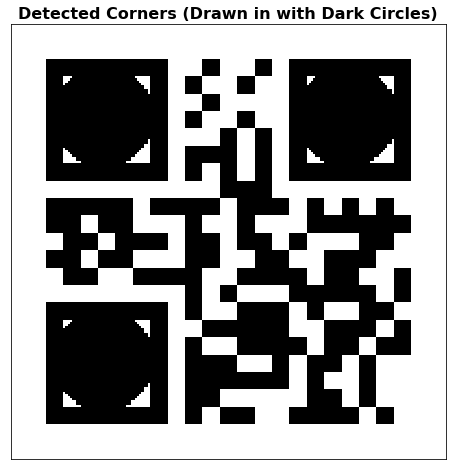

In [4]:
predicted_corners, length, img = find_corners('QR_codes/test1.png', cutoff=0.80, count_cutoff=3)
print(f'NUM DETECTED CORNERS (should be 3): {len(predicted_corners)}')
plt.imshow(np.invert(img), cmap='Greys', interpolation='nearest')
just_title('Detected Corners (Drawn in with Dark Circles)')

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

In [5]:
# Your Code Here
def homography_and_crop(img_file_path, predicted_corners, length, padding=40):
    pred_corners = deepcopy(predicted_corners)

    assert len(pred_corners) == 3

    img_gray = cv2.imread(img_file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    height, width = img.shape

    point_1, point_2, point_3 = pred_corners[0], pred_corners[1], pred_corners[2]
    smallest_point_1 = None
    smallest_x1 = np.inf

    for point in [point_1, point_2, point_3]:
        if point[0] < smallest_x1:
            smallest_point_1 = point
            smallest_x1 = point[0]

    new_points = []

    for point in [point_1, point_2, point_3]:
        if point != smallest_point_1:
            new_points.append(point)

    smallest_point_2 = None
    smallest_x2 = np.inf

    for point in new_points:
        if point[0] < smallest_x2:
            smallest_point_2 = point
            smallest_x2 = point[0]

    smallest_point_3 = None

    for point in [point_1, point_2, point_3]:
        if point != smallest_point_1 and point != smallest_point_2:
            smallest_point_3 = point
            break

    x_offset = smallest_point_2[0] - smallest_point_1[0]
    y_offset = min(smallest_point_1[1], smallest_point_2[1]) - max(smallest_point_1[1], smallest_point_2[1])

    new_x, new_y = smallest_point_3[0] + x_offset, smallest_point_3[1] + y_offset

    if new_x < 0 or new_x > width or new_y < 0 or new_y > height:
        new_x, new_y = smallest_point_3[0] - x_offset, smallest_point_3[1] - y_offset

    pred_corners.append((new_x, new_y))
    assert len(pred_corners) == 4

    new_corner_coordinates = {}

    for j, i in pred_corners:
        # Top-left
        if i / width < 0.5 and j / height < 0.5:
            new_x, new_y = padding / 2 + int(length / 2), padding / 2 + int(length / 2)
            new_corner_coordinates[(i, j)] = (new_x, new_y)

        # Top-right
        elif i / width > 0.5 and j / height < 0.5:
            new_x, new_y = width - 1 + (padding / 2) - int(length / 2), padding / 2 + int(length / 2)
            new_corner_coordinates[(i, j)] = (new_x, new_y)

        # Bottom-left
        elif i / width < 0.5 and j / height > 0.5:
            new_x, new_y = padding / 2 + int(length / 2), height - 1 + (padding / 2) - int(length / 2)
            new_corner_coordinates[(i, j)] = (new_x, new_y)

        # Bottom-right
        elif i / width > 0.5 and j / height > 0.5:
            new_x, new_y = width - 1 + (padding / 2) - int(length / 2), height - 1 + (padding / 2) - int(length / 2)
            new_corner_coordinates[(i, j)] = (new_x, new_y)

        else:
            raise Exception('Invalid corner point')

    assert len(new_corner_coordinates) == 4

    A = []
    b = []

    for original_coordinate, new_coordinate in new_corner_coordinates.items():
        (y_s, x_s), (y_d, x_d) = original_coordinate, new_coordinate

        A.append([x_s, y_s, 1, 0, 0, 0, -x_d * x_s, -x_d * y_s])
        A.append([0, 0, 0, x_s, y_s, 1, -y_d * x_s, -y_d * y_s])
        b.extend([x_d, y_d])

    A = np.array(A).reshape(8, 8)
    b = np.array(b).reshape(-1, 1)

    homography = np.linalg.solve(A, b)
    homography = list(homography.reshape(1, -1)[0])
    homography.append(1)
    homography = np.array(homography).reshape(3, 3)

    padded_shape = (height + padding, width + padding)

    transformed_image = cv2.warpPerspective(img, homography, padded_shape)
    transformed_image = cv2.threshold(transformed_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Crop
    # Whiten on the edges
    for i in range(padded_shape[1]):
        for j in range(padded_shape[0]):
            if i < 0.67 * (padding / 2) or i > padded_shape[1] - 0.6 * (padding / 2) or j < 0.6 * (padding / 2) or j > padded_shape[0] - 0.6 * (padding / 2):
                transformed_image[j][i] = 255

    start_i, stop_i, start_j, stop_j = None, None, None, None

    for i in range(padded_shape[1]):
        for j in range(padded_shape[0]):
            if transformed_image[j][i] == 0:
                start_i, start_j = i, j
                break

    for i in range(padded_shape[1] - 1, -1, -1):
        for j in range(padded_shape[0] - 1, -1, -1):
            if transformed_image[j][i] == 0:
                stop_i, stop_j = i, j
                break
    
    if start_i is None or start_j is None or stop_i is None or stop_j is None:
        raise Exception('Could not properly find crop dimensions')

    return transformed_image[start_j:stop_j, stop_i:start_i]

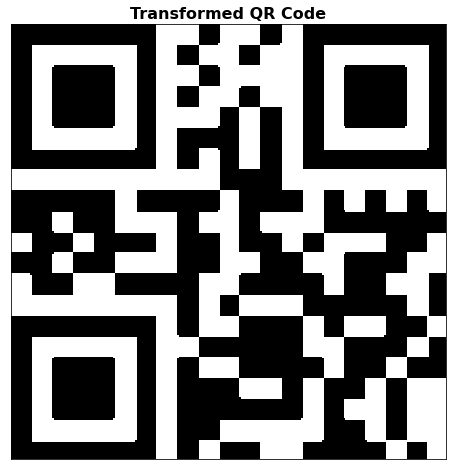

In [6]:
transformed_image = homography_and_crop('QR_codes/test1.png', predicted_corners, length, padding=100)

plt.imshow(np.invert(transformed_image), cmap='Greys', interpolation='nearest')
just_title('Transformed QR Code')

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


In [7]:
# Your Code Here
def discretize(transformed_image, cutoff=0.70):
    img = cv2.threshold(transformed_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    height, width = img.shape

    def _get_lengths(size):
        size_divided = width / size

        size_down, size_mid, size_up = int(np.floor(size_divided)), round(size_divided, 1), int(np.ceil(size_divided))
        size_down_proba = round(size_up - size_mid, 1)

        every_n_iterations = round(1 / size_down_proba) if size_down_proba > 0 else 0
        lengths = []

        for k in range(size):
            if every_n_iterations > 0 and (k + 1) % every_n_iterations == 0:
                lengths.append(size_down)

            else:
                lengths.append(size_up)

        if sum(lengths) != width:
            lengths[-1] = width - sum(lengths[:-1])

        assert len(lengths) == size and sum(lengths) == width

        return lengths

    def _get_size():
        possible_sizes = [21, 25, 29, 33]

        for size in possible_sizes:
            lengths = _get_lengths(size)

            i, discretized_i = 0, 0
            prev = 'white'
            continue_with_size = True

            while i < width and discretized_i < size:
                j, discretized_j = 0, 0
                i_size = lengths[discretized_i]

                while j < height and discretized_j < size:
                    j_size = lengths[discretized_j]

                    if 8 <= discretized_i < 8 + (size - 16) and discretized_j == 6:
                        next_i, next_j = min(i + i_size, width - 1), min(j + j_size, height - 1)
                        curr_slice = img[i:next_i, j:next_j]

                        n_black = (curr_slice == 0).sum()
                        n_white = (curr_slice == 255).sum()
                        n_pixels = curr_slice.shape[0] * curr_slice.shape[1]

                        if prev == 'white' and n_black / n_pixels >= cutoff:
                            prev = 'black'

                        elif prev == 'black' and n_white / n_pixels >= cutoff:
                            prev = 'white'

                        else:
                            continue_with_size = False
                            break

                    j += j_size
                    discretized_j += 1

                if not continue_with_size:
                    break

                i += i_size
                discretized_i += 1

            if continue_with_size:
                return size

        raise Exception('No valid size found')

    size = _get_size()
    
    print(f'DETECTED SIZE: {size}')

    lengths = _get_lengths(size)

    discretized_array = np.full((size, size), 0)

    i, discretized_i = 0, 0

    while i < width and discretized_i < size:
        j, discretized_j = 0, 0
        i_size = lengths[discretized_i]

        while j < height and discretized_j < size:
            j_size = lengths[discretized_j]
            next_i, next_j = min(i + i_size, width - 1), min(j + j_size, height - 1)
            curr_slice = img[i:next_i, j:next_j]

            n_black = (curr_slice == 0).sum()
            n_white = (curr_slice == 255).sum()

            # print(f'{(n_black, n_white)}\n')
            # print(curr_slice)
            # return discretized_array

            discretized_array[discretized_i][discretized_j] = n_white > n_black

            # discretized_array[discretized_i][discretized_j] = val
            # discretized_array1[discretized_i][discretized_j] = val

            j += j_size
            discretized_j += 1

        i += i_size
        discretized_i += 1

    return discretized_array

In [8]:
discretized_array = discretize(transformed_image, cutoff=0.60)

DETECTED SIZE: 21


### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [9]:
from decoder import decode

output = decode(discretized_array)
print(f'Output: {output}')

Output: http://byu.edu


## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

In [10]:
# TEST IMAGE 1
predicted_corners, length, img = find_corners('QR_codes/test1.png', cutoff=0.80, count_cutoff=3)
transformed_image = homography_and_crop('QR_codes/test1.png', predicted_corners, length, padding=100)
discretized_array = discretize(transformed_image, cutoff=0.60)
output = decode(discretized_array)
print(f'Test 1 output: {output}')

# TEST IMAGE 2
predicted_corners, length, img = find_corners('QR_codes/test2.png', cutoff=0.80, count_cutoff=3)
transformed_image = homography_and_crop('QR_codes/test2.png', predicted_corners, length, padding=90)
discretized_array = discretize(transformed_image, cutoff=0.60)
output = decode(discretized_array)
print(f'Test 2 output: {output}')

# TEST IMAGE 3
predicted_corners, length, img = find_corners('QR_codes/test3.png', cutoff=0.80, count_cutoff=3)
transformed_image = homography_and_crop('QR_codes/test3.png', predicted_corners, length, padding=90)
discretized_array = discretize(transformed_image, cutoff=0.60)
output = decode(discretized_array)
print(f'Test 3 output: {output}')

# TEST IMAGE 4
predicted_corners, length, img = find_corners('QR_codes/test4.png', cutoff=0.80, count_cutoff=3)
transformed_image = homography_and_crop('QR_codes/test4.png', predicted_corners, length, padding=90)
discretized_array = discretize(transformed_image, cutoff=0.60)
output = decode(discretized_array)
print(f'Test 4 output: {output}')

# TEST IMAGE 5
predicted_corners, length, img = find_corners('QR_codes/test5.png', cutoff=0.80, count_cutoff=3)
transformed_image = homography_and_crop('QR_codes/test5.png', predicted_corners, length, padding=90)
discretized_array = discretize(transformed_image, cutoff=0.60)
output = decode(discretized_array)
print(f'Test 5 output: {output}')


DETECTED SIZE: 21
Test 1 output: http://byu.edu
DETECTED SIZE: 21
Test 2 output: http://byu.edu
DETECTED SIZE: 21
Test 3 output: http://byu.edu
DETECTED SIZE: 21
Test 4 output: http://byu.edu
DETECTED SIZE: 29
Test 5 output: http://DataGenetics.com


## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



In [11]:
# CHALLENGE IMAGE 3
predicted_corners, length, img = find_corners('QR_codes/challenge3.png', cutoff=0.80, count_cutoff=3)
transformed_image = homography_and_crop('QR_codes/challenge3.png', predicted_corners, length, padding=200)
discretized_array = discretize(transformed_image, cutoff=0.60)
output = decode(discretized_array)
print(f'Challenge 3 output: {output}')

DETECTED SIZE: 21
Challenge 3 output: http://byu.edu


DETECTED SIZE: 29
The majority of my algorithm for challenge image #4 works except for the final decoding part (see my comments at the top of this code cell).
Exception: 'Parsed Result'


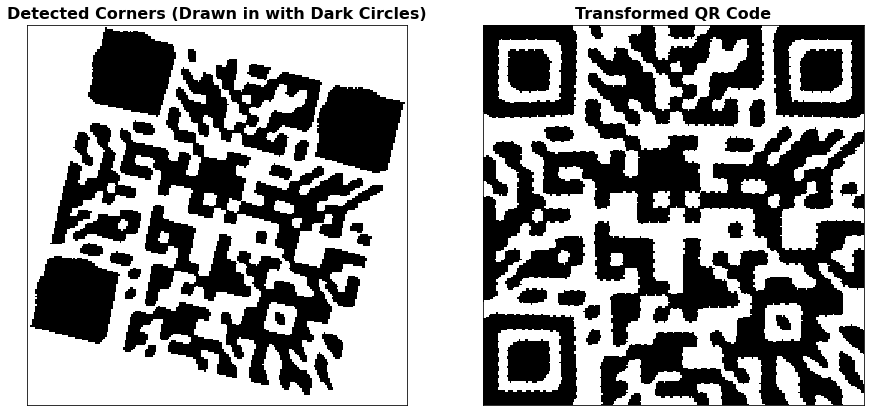

In [12]:
# CHALLENGE IMAGE 4
# ***** PLEASE NOTE *****: Most of my algorithm works for this image, though the discretization part appears to be having issues
# (it correctly finds the proper bin size of 29, but there must be an issue with the binary values it assigns because an error is
# returned from the endpoint used for decoding).  Hopefully you will be willing to assign at least a portion of the 15 points as 
# partial credit since the majority of my algorithm still seems to work (I included plots of those parts so that you can easily 
# verify).
predicted_corners, length, img = find_corners('QR_codes/challenge4.png', cutoff=0.60, count_cutoff=3)
plt.subplot(121)
plt.imshow(np.invert(img), cmap='Greys', interpolation='nearest')
just_title('Detected Corners (Drawn in with Dark Circles)')

transformed_image = homography_and_crop('QR_codes/challenge4.png', predicted_corners, length, padding=70)
plt.subplot(122)
plt.imshow(np.invert(transformed_image), cmap='Greys', interpolation='nearest')
just_title('Transformed QR Code')

discretized_array = discretize(transformed_image, cutoff=0.30)

try:
    output = decode(discretized_array)

except Exception as e:
    print(f'The majority of my algorithm for challenge image #4 works except for the final decoding part (see my comments at the top of this code cell).\nException: {e}')


## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?


Your Write-up Here

* <span style="color:red;">Which part of this lab did you find most difficult?</span>  The first part (detecting the corners) was probably the hardest as well as the most time-consuming.  I ended up just doing a (fairly long) for-loop for one direction and then copied and pasted that code for 3 other directions.  It would've been nice to go back and clean all of that up but I've already spent way too much time on this lab.
* <span style="color:red;">For each challenge completed, explain how you were able to solve the problem presented.</span>  For part A it was just a matter of thinking through the logic and how to account for different images, rotations, etc.  Part B was relatively straightforward, although I made a few errors and it took me a while to debug.  I also spent a good amount experimenting with different things and found that adding some white padding around the image seemed to help with the transformation and cropping.  For Part C I again just had to think through some looping logic in order to find the correct discretization size.  Part D was just a matter of passing the binary array to the given endpoint.  As I worked on each part I experimented with the different test images, so when everything was finished I thankfully was able to get valid results for those five images.  For challenge image 3 I just had to think about how to make a few tweaks when transforming and cropping the image due to several black areas around the actual QR code.  For challenge image 4 I pretty much ran out of gas (I've spent a good 15+ hours on this lab), though thankfully the majority of my algorithm seems to work.  The only issue appears with creating the binary array; my guess is that, since some of the QR code is blurred, the discretization is thrown off a little bit.  That's where I would look/play around if I had more time.
* <span style="color:red;">What improvements would you recommend for this lab?</span>  Once again I found that the lab took an incredible amount of time.  At this point it might just be me; it's never taken me this long to complete labs for other CS classes, and I haven't heard/seen any major complaints in class or on Discord, so I guess I'm just really bad at computer vision.